# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

The goal is to modify LeNet to identify German traffic signs in 43 categories. LeNet convolution of two layers, three layers fully connected, I added a layer of convolution, modify the kernel size. Further, the addition of the whole dropou connecting layer for preventing over-fitting. Under this process to build the network of record, summarize method TensorFlow to build and train a network of convolution.


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.contrib.layers import flatten
# TODO: Fill this in based on where you saved the training and testing data

#training_file = ?
#validation_file=?
#testing_file = ?

training_file = "traffic-signs-data/train.p"
validation_file= "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

The training, verification, and test sets each have 34799, 4410, and 12630 pictures, all of which are (32, 32, 3), with a total of 43 categories.

In [2]:
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Training Set:   {} samples".format(len(y_train)))
print("Validation Set: {} samples".format(len(X_valid)))
print("Test Set:       {} samples".format(len(X_test)))


Image Shape: (32, 32, 3)

Training Set:   34799 samples
Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples


41


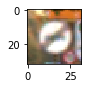

In [3]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

----

## Step 2: Data augment.

I used two particularly simple methods to expand the data set: one is to turn the pictures to gray, that is, to take the pixels on the three channels as their average; the other is to add one to each picture An integer up to 100.
But not all the data was used. Considering that I used CPU training, I only used more than 50,000 pictures.Design and Test a Model Architecture.


In [4]:
"""
Data Augmen
"""
n_classes = y_train.max() + 1
n_train = X_train.shape[0]
# 第二种方法，先随机生成X_train.shape[0]个正整数
bias = np.random.randint(0,100,(n_train,1,1,1))
# broadcasting，并保证范围都在[0,255]以内
X_train_aug0 = np.clip(X_train+bias, 0, 255).astype(np.uint8)
y_train_aug0 = y_train

# 沿各个图片的channel取均值
# 本来为(34799, 32, 32, 3)，取均值后为(34799, 3, 3, 1)
a = np.mean(X_train,axis=3,keepdims=True).astype(np.uint8)
# 将均值扩到3个channel，(34799, 3, 3, 1)->(34799, 32, 32, 3)
X_train_aug1 = np.concatenate((a,a,a),axis=3)
y_train_aug1 = y_train

X_train_aug = np.concatenate((X_train_aug0,X_train_aug1), axis=0)
y_train_aug = np.concatenate((y_train_aug0,y_train_aug1), axis=0)

# 保存新数据
with open('traffic-signs-data/train_aug.p','wb') as f:
    pickle.dump(dict(features=X_train_aug, 
                     labels=y_train_aug, 
                     sizes=np.concatenate((train['sizes'],train['sizes']),axis=0),
                     coords=np.concatenate((train['coords'],train['coords']),axis=0)), 
                f)

# 添加到训练集，只使用了四分之一的新数据
# 现在训练集有52199张图片
X_train = np.concatenate((X_train,X_train_aug[0:-1:4,:,:,:]), axis=0)
y_train = np.concatenate((y_train,y_train_aug[0:-1:4]), axis=0)

In [5]:
# zero out the mean
train_image_mean = np.mean(X_train, axis=0)
X_train_norm = X_train - train_image_mean
# normalize the variance
train_image_std = np.std(X_train_norm, axis=0)
X_train_norm = X_train_norm / train_image_std

In [6]:
X_valid_norm = X_valid - train_image_mean
X_valid_norm = X_valid / train_image_std

X_test_norm = X_test - train_image_mean
X_test_norm = X_test / train_image_std

## Step 3: Build a network.

In [7]:
mu = 0
sigma = 0.1
# trainable用于控制卷积层和全连接层是否训练，记不得当时我为什么要控制这个了......
# regularizer是想传入通过tf.contrib.layers.l2_regularizer()返回的函数来着。
# 将其用于regularize全连接层参数，但是训练效果不好，最后就没用
def initialize_parameters(trainable=[True,True], regularizer=None):
    # 将创建好的变量放入字典中返回
    parameters = {}
    with tf.variable_scope('parameters', reuse=tf.AUTO_REUSE):
# Layer 1: Convolutional. 
        # 每一层都用了variable_scope，并设置了reuse=tf.AUTO_REUSE，配合tf.get_variable()达到共享变量的目标。没有变量时创建，有的话就调用创建好的。
        with tf.variable_scope('conv1', reuse=tf.AUTO_REUSE):
            # 第一个卷基层的kernel，3x3，输入#channel，输出#channel
            conv1_W = tf.get_variable("conv1_W", [3,3,3,16], 
                              initializer = tf.truncated_normal_initializer(mu,sigma), dtype=tf.float32,
                              trainable=trainable[0]) 
            # 除了kernel以外，别忘了bias
            conv1_b = tf.get_variable("conv1_b", [1,1,1,16],
                              initializer = tf.zeros_initializer(), dtype=tf.float32,
                              trainable=trainable[0])
            parameters["conv1_W"] = conv1_W 
            parameters["conv1_b"] = conv1_b 
    
# Layer 2: Convolutional. 
        with tf.variable_scope('conv2', reuse=tf.AUTO_REUSE):
            conv2_W = tf.get_variable("conv2_W", [3,3,16,32],
                              initializer = tf.truncated_normal_initializer(mu,sigma), dtype=tf.float32,
                              trainable=trainable[0]) 
            conv2_b = tf.get_variable("conv2_b", [1,1,1,32],
                              initializer = tf.zeros_initializer(), dtype=tf.float32,
                              trainable=trainable[0])
            parameters["conv2_W"] = conv2_W 
            parameters["conv2_b"] = conv2_b 

    
# Layer 3: Convolutional.
        with tf.variable_scope('conv3', reuse=tf.AUTO_REUSE):
            conv3_W = tf.get_variable("conv3_W", [3,3,32,64],
                              initializer = tf.truncated_normal_initializer(mu,sigma), dtype=tf.float32,
                              trainable=trainable[0]) 
            conv3_b = tf.get_variable("conv3_b", [1,1,1,64],
                              initializer = tf.zeros_initializer(), dtype=tf.float32,
                              trainable=trainable[0])
    
            parameters["conv3_W"] = conv3_W 
            parameters["conv3_b"] = conv3_b 

    
# Layer 4: Fully Connected. 
        with tf.variable_scope('fc1', reuse=tf.AUTO_REUSE):
            fc1_W = tf.get_variable("fc1_W", [576,120],
                            initializer=tf.truncated_normal_initializer(mu,sigma), dtype=tf.float32,
                            trainable=trainable[1]) 
            fc1_b = tf.get_variable("fc1_b", [1,120],
                            initializer=tf.zeros_initializer(), dtype=tf.float32,
                            trainable=trainable[1])
            parameters["fc1_W"] = fc1_W 
            parameters["fc1_b"] = fc1_b 

    
# Layer 5: Fully Connected. 
        with tf.variable_scope('fc2', reuse=tf.AUTO_REUSE):
            fc2_W = tf.get_variable("fc2_W", [120,84],
                            initializer=tf.truncated_normal_initializer(mu,sigma), dtype=tf.float32,
                            trainable=trainable[1]) 
            fc2_b = tf.get_variable("fc2_b", [1,84],
                            initializer=tf.zeros_initializer(), dtype=tf.float32,
                            trainable=trainable[1])
            parameters["fc2_W"] = fc2_W 
            parameters["fc2_b"] = fc2_b 

    
# Layer 6: Fully Connected. 
        with tf.variable_scope('fc3', reuse=tf.AUTO_REUSE):
            fc3_W = tf.get_variable("fc3_W", [84,n_classes],
                            initializer=tf.truncated_normal_initializer(mu,sigma), dtype=tf.float32,
                            trainable=trainable[1]) 
            fc3_b = tf.get_variable("fc3_b", [1,n_classes],
                            initializer=tf.zeros_initializer(), dtype=tf.float32,
                            trainable=trainable[1])
            parameters["fc3_W"] = fc3_W 
            parameters["fc3_b"] = fc3_b 
            
    # add l2_regularization to collection 'regularize'
    # 如果传入了用于normalize的函数，则将对全连接层权值normalize的tensor加入集合'regularize'中。在cost函数中通过集合加入这些regularize项。
    if regularizer != None:
        tf.add_to_collection('regularize', regularizer(fc1_W))
        tf.add_to_collection('regularize', regularizer(fc2_W))
        tf.add_to_collection('regularize', regularizer(fc3_W))
    else:
        # 如果没有传入regularize函数，则在集合中加个常量0就好。
        # 因为后面使用tf.add_n(tf.get_collection('regularize'))来调出集合中的tensor
        # 若集合为空则会报错的。
        tf.add_to_collection('regularize', tf.constant(0., dtype=tf.float32))
    
    # 各个可训练的参数都在改字典中了
    # 搭建网络结构时调用就好
    return parameters

## Step 4: Network forward propagation.

In [8]:
# x为建立的placeholder，为(None, 32, 32, 3)
# parameters就是上一函数的返回
# keep_prob用于控制各层dropout的概率。卷基层概率都设为1。
# 必须通过参数控制。
# 因为在训练过程中和在测试网络性能过程中其值不同。
# 返回的tensor logits为全连接的输出，为(None, 43)，没有接softmax
# 因为后面使用的是tf.nn.softmax_cross_entropy_with_logits()来构造cost
def LeNet_forwardpass(x, parameters, keep_prob):    
# Layer 1: Convolutional. Input = 32x32x3. Output = 32x32x16.
    conv1_W = parameters["conv1_W"]
    conv1_b = parameters["conv1_b"]
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1,1,1,1], padding='SAME') + conv1_b
    # Activation.
    conv1   = tf.nn.leaky_relu(conv1, name="conv1_out")

    # Pooling. Input = 32x32x16. Output = 16x16x16.
    conv1   = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # dropout
    conv1   = tf.nn.dropout(conv1, keep_prob=keep_prob[0])

# Layer 2: Convolutional. Input = 16x16x16. Output = 16x16x32.
    conv2_W = parameters["conv2_W"]
    conv2_b = parameters["conv2_b"]
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1,1,1,1], padding='SAME') + conv2_b
    
    # Activation.
    conv2   = tf.nn.leaky_relu(conv2, name="conv2_out")

    # Pooling. Input = 16x16x32. Output = 8x8x32.
    conv2   = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # dropout
    conv2   = tf.nn.dropout(conv2, keep_prob=keep_prob[1])

# Layer 3: Convolutional. Input = 8x8x32. Output = 8x8x64.
    conv3_W = parameters["conv3_W"]
    conv3_b = parameters["conv3_b"]
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1,1,1,1], padding='SAME') + conv3_b
    
    # Activation.
    conv3   = tf.nn.leaky_relu(conv3, name="conv3_out")
    
    # Pooling. Input = 8x8x64. Output = 3x3x64.
    conv3   = tf.nn.max_pool(conv3, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # dropout
    conv3   = tf.nn.dropout(conv3, keep_prob=keep_prob[2])

# Flatten. Input = 3x3x64. Output = 576.
    fc0     = flatten(conv3)
    
# Layer 4: Fully Connected. Input = 576. Output = 120.
    fc1_W = parameters["fc1_W"]
    fc1_b = parameters["fc1_b"]
    fc1     = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1     = tf.nn.leaky_relu(fc1, name="fc1_out")
    # Dropout
    fc1     = tf.nn.dropout(fc1, keep_prob=keep_prob[3])

# Layer 5: Fully Connected. Input = 120. Output = 84.
    fc2_W = parameters["fc2_W"]
    fc2_b = parameters["fc2_b"]
    fc2   = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2     = tf.nn.leaky_relu(fc2, name="fc2_out")
    # Dropout
    fc2     = tf.nn.dropout(fc2, keep_prob=keep_prob[4])

# Layer 6: Fully Connected. Input = 84. Output = n_classes.
    fc3_W = parameters["fc3_W"]
    fc3_b = parameters["fc3_b"]
    logits  = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

## Step 5: Create input and output placeholders.

In [9]:
x = tf.placeholder(dtype=tf.float32, shape=(None, 32, 32, 3))
y = tf.placeholder(dtype=tf.int32, shape=(None))
keep_prob = tf.placeholder(dtype=tf.float32, shape=(5))
# one_hot_y为(None, 43)，每一行只有一个1，其他为0.
one_hot_y = tf.one_hot(y, n_classes)

## Step 6: cost and optimizer.

In [10]:
# 训练的epoch和batch size
EPOCHS = 25
BATCH_SIZE = 128

# 初始学习率
rate = 0.005
# 下降率
decay_rate = 0.8
# 多少次一下降
decay_steps = 500
trainable = [True,True] 
lamb = 0.01

# 返回的regularizer是一个函数，可以对输入tensor计算正则项
regularizer = tf.contrib.layers.l2_regularizer(lamb)

# 调用上面的函数建立参数
parameters = initialize_parameters(trainable, regularizer=None)
# 前向传播得到输出
logits = LeNet_forwardpass(x, parameters, keep_prob)
# 对网络的输出softmax后与label计算cross entropy
# 返回的是各个example的cross entropy，下面要对其求平均
# 该API不再推荐了，推荐使用v2版本
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

# 求平均后，加上regularization项，但这里别没有
loss_operation = tf.reduce_mean(cross_entropy) + tf.add_n(tf.get_collection('regularize'))

# learning rate decay
# 这个global_step是一个不可训练的变量，需要传给优化器对象的minimize方法
# 在训练时，每一次优化都会对其加1
global_step = tf.Variable(0, trainable=False)
# 返回的为tensor，可看文档，是对初始学习率decay的学习率tensor。
decay_rate = tf.train.exponential_decay(decay_rate=decay_rate, decay_steps=decay_steps, 
                                        global_step=global_step, learning_rate=rate)

# 建立优化器对象。learning_rate参数可传入浮点数或tensor
# 这里就传入的tensor
optimizer = tf.train.AdamOptimizer(learning_rate = decay_rate)
# trainig_operation是一个Operation，指出优化的是loss_operation.
# 文档中也说了：If global_step was not None, that operation also increments global_step.
# 现在传入了global_step，那么每次执行该Operation就会对global_step加1.
training_operation = optimizer.minimize(loss_operation, global_step=global_step)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Step 7: Evaluation function.

In [11]:
# 很简单，accuracy_operation也就是准去率tensor了
correct_prediction = tf.equal(tf.argmax(logits, 1, output_type=tf.int32), y)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 建立个函数在Session中调用，方便
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    # 这里是按batch评估准确率，最后计算总准确率了
    # 这样的话应该运行速度比一次计算整体数据集的准确率快。
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        # 因为是测试模型准确率，所以dropout概率为1，就是没有dropout。
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: [1.0,1.0,1.0,1.0,1.0]})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# 建立各Saver对象用于训练完成后保存模型。
saver = tf.train.Saver()


## Step 8: Train the Model.

In [12]:
# 用于在每次epoch中shuffle数据集
from sklearn.utils import shuffle

# 记录每次训练后batch上的cost值
cost = []
# 记录训练完一个epoch后，在整个数据集上的cost。
cost_epoch = []
# keep_prob
# 训练时dropout的概率，卷积层不dropout
k = [1.,1.,1.,0.4,0.5]
with tf.Session() as sess:
    # 可别忘了初始化全局变量
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_norm)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        # 这里shuffle的数据集。感觉弄一个数据集的索引列表，
        # shuffle该列表应该快一些。
        X_train_norm, y_train = shuffle(X_train_norm, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            # 在numpy中不用担心索引超出数组边界。
            batch_x, batch_y = X_train_norm[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: k})
            loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: [1.0,1.0,1.0,1.0,1.0]})
            cost.append(loss)
        
        loss = sess.run(loss_operation, feed_dict={x: X_train_norm, y: y_train, keep_prob: [1.0,1.0,1.0,1.0,1.0]})
        cost_epoch.append(loss)
        
        # 分别在训练、测试集上评估正确率。
        train_accuracy = evaluate(X_train_norm, y_train)    
        validation_accuracy = evaluate(X_valid_norm, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.5f}".format(train_accuracy))
        print("Validation Accuracy = {:.5f}".format(validation_accuracy))
        print()
        
    # 保存训练好的模型
    saver.save(sess, './model/model.ckpt')
    print("Model saved")


Training...

EPOCH 1 ...
Train Accuracy = 0.88366
Validation Accuracy = 0.78118

EPOCH 2 ...
Train Accuracy = 0.95944
Validation Accuracy = 0.87574

EPOCH 3 ...
Train Accuracy = 0.97726
Validation Accuracy = 0.93016

EPOCH 4 ...
Train Accuracy = 0.98866
Validation Accuracy = 0.93764

EPOCH 5 ...
Train Accuracy = 0.98935
Validation Accuracy = 0.95510

EPOCH 6 ...
Train Accuracy = 0.99167
Validation Accuracy = 0.93946

EPOCH 7 ...
Train Accuracy = 0.99452
Validation Accuracy = 0.94354

EPOCH 8 ...
Train Accuracy = 0.99697
Validation Accuracy = 0.95351

EPOCH 9 ...
Train Accuracy = 0.99787
Validation Accuracy = 0.95510

EPOCH 10 ...
Train Accuracy = 0.99787
Validation Accuracy = 0.96327

EPOCH 11 ...
Train Accuracy = 0.99881
Validation Accuracy = 0.96281

EPOCH 12 ...
Train Accuracy = 0.99902
Validation Accuracy = 0.96417

EPOCH 13 ...
Train Accuracy = 0.99933
Validation Accuracy = 0.96531

EPOCH 14 ...
Train Accuracy = 0.99933
Validation Accuracy = 0.96939

EPOCH 15 ...
Train Accuracy = 

---
## Step 9: Evaluation test set


In [13]:
with tf.Session() as sess:
    # restore的过程就相当于将保存的训练好的模型加载到当前graph中
    # 构建好的结构中。在这一过程中，各变量的值都被初始化为保存好的
    # 变量的值。
    # 也就不需要再调用sess.run(tf.global_variables_initializer())了
    saver.restore(sess, './model/model.ckpt')

    test_accuracy = evaluate(X_test_norm, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt
Test Accuracy = 0.945
